# Projet BIRD 

Maxime Muhlethaler & Titouan Pottier

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.fftpack import fft
import numpy as np
from scipy.special import erfinv
from joblib import Parallel, delayed
import mne

# MDCT 

## Bloc MDCT à plusieurs échelle s


Dans ce bloc, on met en place une **représentation temps–fréquence** avec la **MDCT** à plusieurs échelles.  
L’idée : projeter le signal sur un dictionnaire temps–fréquence qui servira ensuite pour le débruitage parcimonieux.

`framing(a, L)`

- On découpe le signal en trames de longueur $L$ avec un **overlap de 50 %**.  
- On obtient une matrice $L \times N_{\text{trames}}$ où chaque colonne est une trame.

`mdct(x, L)`

- On calcule la **MDCT** d’un signal 1D $x$ avec une fenêtre de taille $L$.  
- Chaque trame donne $K = L/2$ coefficients MDCT.  
- Au final, on obtient un grand vecteur de coefficients temps–fréquence pour cette échelle.

`get_atom(L, freq_idx)`

- On reconstruit un **atome temporel** associé à un indice de fréquence MDCT `freq_idx`.  
- Cet atome correspond à une colonne du dictionnaire, normalisée à $\|a\|_2 = 1$.

Classe `MDCT`

- On stocke une liste de tailles de fenêtres `scales` (par ex. $[256, 512, 1024]$).  
- La méthode `doth(x)` applique la MDCT pour chaque $L$ dans `scales` et **concatène** tous les coefficients :
  \[
  \Phi^\top x = \big[ \text{MDCT}_{L_1}(x), \ \text{MDCT}_{L_2}(x), \dots \big].
  \]
- On obtient ainsi une **représentation multi-échelle surcomplète** qui servira de base pour le débruitage.

In [2]:
def framing(a, L):
    """Découpe rapide en trames (Overlap 50%)"""
    shape = a.shape[:-1] + (a.shape[-1] - L + 1, L)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::L // 2].T.copy()

def mdct(x, L):
    """MDCT Forward (Analyse)"""
    x = np.array(x, dtype=float)
    N = x.size
    K = L // 2
    if N % K != 0: raise ValueError(f"Taille incorrecte: {N} n'est pas multiple de {K}")

    # 1. Repliement (Folding)
    xx = np.zeros(L // 4 + N + L // 4)
    xx[L // 4 : -L // 4] = x
    
    # 2. Fenêtrage (Princen-Bradley)
    frames = framing(xx, L)
    t = np.arange(L, dtype=float)
    w = np.sin(np.pi / L * (t + 0.5))
    
    # Bords spéciaux pour reconstruction parfaite
    w_start, w_end = w.copy(), w.copy()
    w_start[:L//4] = 0; w_start[L//4:K] = 1
    w_end[K:K+L//4] = 1; w_end[K+L//4:] = 0
    
    frames[:, 0] *= w_start
    frames[:, 1:-1] *= w[:, None]
    frames[:, -1] *= w_end

    # 3. FFT et Rotation
    frames_c = frames.astype(complex) * np.exp(-1j * np.pi / L * t)[:, None]
    spec = fft(frames_c, axis=0)
    spec = spec[:K, :] * np.exp(-1j * np.pi * (K + 1) / L * (0.5 + t[:K]))[:, None]
    
    return math.sqrt(2. / K) * np.real(spec).ravel()

def get_atom(L, freq_idx):
    """Synthèse d'un atome (Inverse MDCT)"""
    K = L / 2
    t = np.arange(L, dtype=float)
    fact = math.sqrt(2.0 / K)
    
    # Phase exacte pour correspondre à l'analyse
    phase = (np.pi / K) * (freq_idx + 0.5) * ((t - K/2.0) + (L+1.0)/2.0)
    window = np.sin(np.pi / L * (t + 0.5))
    
    atom = fact * window * np.cos(phase)
    return atom / np.linalg.norm(atom)

class MDCT:
    """Conteneur simple"""
    def __init__(self, scales):
        self.scales = scales
        
    def doth(self, x):
        if x.ndim == 1:
            return np.concatenate([mdct(x, L) for L in self.scales])
        return np.array([self.doth(row) for row in x])

### Bloc BIRD


Ici, on implémente l'algorithme **BIRD** comme décrit dans le papier.

`run_bird(x, scales, lambda_stop, seed)`

- On pad le signal, on initialise un **résidu** et une **estimation** `x_est`.
- À chaque itération, pour chaque échelle $L$ dans `scales` :
  - on calcule la MDCT du résidu,
  - on empile tous les coefficients dans un grand vecteur.
- On prend le **plus gros coefficient**, on reconstruit l’atome associé et :
  - on l’ajoute à `x_est`,
  - on le retire du résidu.
- On met à jour un $\lambda$ basé sur la baisse de la norme du résidu et on s’arrête dès que $\lambda \le \lambda_{\text{stop}}$.

`bird(X, scales, n_runs=20, p_above=1e-7, n_jobs=1)`

- On calcule la longueur $N$ (après padding) et le nombre total de coefficients $M$ (toutes échelles, tout le temps).
- On en déduit le **seuil théorique** $\lambda_{\text{stop}}$ à partir de $p_{\text{above}}$ via la formule théorique du papier et redémontrée.
- Pour chaque signal / canal, on lance `run_bird` **plusieurs fois** avec des graines différentes, puis on **moyenne** toutes les estimations.
- On obtient un signal débruité, reconstruit à partir d’atomes MDCT multi-échelle, avec un critère d’arrêt sans connaître le niveau de bruit.

In [3]:
def pad_power2(X):
    n = X.shape[1]
    p = int(np.log2(n))
    pad = 2**(p+1) - n
    return np.hstack((np.zeros((X.shape[0], pad)), X)), pad

def run_bird(x, scales, lambda_stop, seed):
    rng = np.random.RandomState(seed)
    
    # Padding de travail
    pad = int(1.5 * max(scales))
    x_work = np.concatenate((np.zeros(pad), x, np.zeros(pad)))
    n = len(x_work)
    
    # Résidu et Estimation
    residual = np.concatenate((x_work, np.zeros(max(scales)//2)))
    x_est = np.zeros(n)
    
    # On calcule la taille totale une fois pour pré-allouer
    dico = MDCT(scales)
    total_coeffs = dico.doth(x_work).size
    coeffs_buffer = np.zeros(total_coeffs)
    
    errs = [np.linalg.norm(residual)]
    curr_lambda = 1.0
    
    for _ in range(100): # Max 100 itérations
        if curr_lambda <= lambda_stop: break
            
        # 1. Analyse (Shifts aléatoires)
        rnd_shifts = []
        for i, L in enumerate(scales):
            shift = rng.randint(0, L//4)
            rnd_shifts.append(shift)
            coeffs_buffer[i*n : (i+1)*n] = mdct(residual[shift:shift+n], L)
            
        # 2. Sélection
        idx = np.argmax(np.abs(coeffs_buffer))
        val = coeffs_buffer[idx]
        
        # 3. Décodage
        s_idx = idx // n
        L = scales[s_idx]
        K = L // 2
        local_idx = idx % n
        freq = local_idx // (n // K)
        frame = local_idx % (n // K)

        # 4. Mise à jour
        atom = get_atom(L, freq)
        pos = frame*K - L//4 + rnd_shifts[s_idx]
        
        start, end = max(0, pos), min(len(residual), pos+L)
        a_start, a_end = start-pos, start-pos+(end-start)
        
        if end > start:
            contrib = val * atom[a_start:a_end]
            residual[start:end] -= contrib
            
            est_end = min(len(x_est), end)
            if est_end > start: x_est[start:est_end] += contrib[:est_end-start]
            
        # 5. Lambda & Sécurité (CORRECTION ICI)
        err_new = np.linalg.norm(residual)
        ratio = err_new / errs[-1]
        errs.append(err_new)
        ratio = min(1.0, ratio)
            
        curr_lambda = np.sqrt(1.0 - ratio)
        
        # Rollback si seuil atteint
        if curr_lambda <= lambda_stop:
            if est_end > start: x_est[start:est_end] -= contrib[:est_end-start]
            break
            
    return x_est[pad:-pad]

def bird(X, scales, n_runs=20, p_above=1e-7, n_jobs=1):
    X = np.asarray(X)
    is_1d = (X.ndim == 1)
    if is_1d: X = X[np.newaxis, :]
        
    X_pad, pad_len = pad_power2(X)
    N = float(X_pad.shape[1])
    
    # Seuil théorique
    M = np.sum(np.array(scales)//2) * N
    sigma = np.sqrt((1 - 2/np.pi) / N)
    l_stop = sigma * np.sqrt(2) * erfinv((1 - p_above)**(1/M))
    
    print(f"BIRD: Lambda={l_stop:.4f}")
    
    # Run parallèle
    seeds = np.random.randint(0, 100000, n_runs)
    denoised = np.zeros_like(X_pad)
    
    for c in range(X.shape[0]):
        res = Parallel(n_jobs=n_jobs)(delayed(run_bird)(X_pad[c], scales, l_stop, s) for s in seeds)
        denoised[c] = np.mean(res, axis=0)
        
    res = denoised[:, pad_len:]
    return res[0] if is_1d else res

### Bloc S-BIRD : débruitage multi-canaux



Ici, on implémente **S-BIRD**, la version multi-capteurs de BIRD.  
On débruite plusieurs signaux en même temps (par ex. plusieurs capteurs) en utilisant une structure commune.

`run_sbird(X, scales, lambda_stop, p_active, seed)`

- `X` contient $n_{\text{ch}}$ canaux (lignes) et le temps (colonnes).  
- On initialise un **résidu** et une **estimation** par canal.

À chaque itération :

1. **Analyse MDCT par canal**  
   Pour chaque échelle $L$ :
   - on calcule la MDCT de chaque canal,
   - on stocke tous les coefficients dans `coeffs`.

2. **Vote structuré**  
   - On regarde l’“énergie” des coefficients sur tous les canaux,
   - on garde les $n_{\text{active}} = p_{\text{active}} \cdot n_{\text{ch}}$ canaux les plus actifs,
   - on choisit l’indice avec le **vote moyen maximal** → atome commun à activer.

3. **Mise à jour par canal**  
   - On reconstruit l’atome (`get_atom(L, freq)`),
   - pour chaque canal, on applique l’amplitude correspondante `amp = coeffs[c, idx]`,
   - on met à jour le résidu et l’estimation `X_est`.

4. **Critère d’arrêt commun**  
   - On calcule un $\lambda$ par canal à partir de la baisse de norme du résidu,
   - on moyenne les plus grands $\lambda$ (les canaux actifs),
   - si $\lambda \le \lambda_{\text{stop}}$, on s’arrête.

La fonction renvoie `X_est` sans le padding.

`sbird(X, scales, n_runs=20, p_above=1e-7, p_active=1.0, n_jobs=1)`

- On pad les signaux à une longueur puissance de 2 (comme pour BIRD).  
- On calcule le **seuil théorique** $\lambda_{\text{stop}}$ à partir de $N$ et du nombre total de coefficients $M$.  
- On lance `run_sbird` **plusieurs fois** avec des graines différentes, puis on **moyenne** les résultats.  

Au final, on obtient un **débruitage multi-canaux**, où les atomes sont sélectionnés en fonction de ce qui est cohérent **à travers les capteurs**.

In [4]:
def run_sbird(X, scales, lambda_stop, p_active, seed):
    rng = np.random.RandomState(seed)
    n_ch, _ = X.shape
    n_active = max(1, int(n_ch * p_active))
    
    pad = int(1.5 * max(scales))
    X_work = np.pad(X, ((0,0), (pad, pad)), mode='constant')
    n = X_work.shape[1]
    
    residual = np.hstack((X_work, np.zeros((n_ch, max(scales)//2))))
    X_est = np.zeros_like(X_work)
    
    # Pré-allocation coeffs
    dico = MDCT(scales)
    n_projs = dico.doth(X_work).shape[1]
    coeffs = np.zeros((n_ch, n_projs))
    
    errs = {c: [np.linalg.norm(residual[c])] for c in range(n_ch)}
    curr_lambda = 1.0
    
    for _ in range(100):
        if curr_lambda <= lambda_stop: break
            
        # 1. Analyse (Shifts)
        rnd_shifts = {c: [] for c in range(n_ch)}
        for i, L in enumerate(scales):
            shift = rng.randint(0, L//4)
            for c in range(n_ch):
                coeffs[c, i*n:(i+1)*n] = mdct(residual[c, shift:shift+n], L)
                rnd_shifts[c].append(shift)
                
        # 2. Vote Structuré (Double Carré fidèle au papier)
        energies = np.sort((coeffs**2)**2, axis=0) 
        votes = np.mean(energies[-n_active:], axis=0)
        idx = np.argmax(votes)
        
        # 3. Décodage
        s_idx = idx // n
        L = scales[s_idx]
        K = L // 2
        local = idx % n
        freq = local // (n//K)
        frame = local % (n//K)
        
        atom = get_atom(L, freq)
        lambdas_step = []
        
        # 4. Update par canal
        for c in range(n_ch):
            amp = coeffs[c, idx]
            shift = rnd_shifts[c][s_idx]
            pos = frame*K - L//4 + shift
            
            start, end = max(0, pos), min(residual.shape[1], pos+L)
            a_start, a_end = start-pos, start-pos+(end-start)
            
            if end > start:
                contrib = amp * atom[a_start:a_end]
                residual[c, start:end] -= contrib
                
                est_end = min(X_est.shape[1], end)
                if est_end > start: X_est[c, start:est_end] += contrib[:est_end-start]
                
            # Sécurité anti-crash
            err_new = np.linalg.norm(residual[c])
            ratio = err_new / errs[c][-1]
            errs[c].append(err_new)
            
            if ratio < 1.0:
                lambdas_step.append(np.sqrt(1.0 - ratio))
            else:
                lambdas_step.append(0.0) # On force 0 si l'erreur augmente
                
        # Moyenne des lambdas
        lambdas_step.sort()
        curr_lambda = np.mean(lambdas_step[-n_active:])
        
    return X_est[:, pad:-pad]

def sbird(X, scales, n_runs=20, p_above=1e-7, p_active=1.0, n_jobs=1):
    X_pad, pad_len = pad_power2(np.asarray(X))
    N = float(X_pad.shape[1])
    
    # Seuil
    M = np.sum(np.array(scales)//2) * N
    sigma = np.sqrt((1 - 2/np.pi) / N)
    l_stop = sigma * np.sqrt(2) * erfinv((1 - p_above)**(1/M))
    
    print(f"S-BIRD: Lambda={l_stop:.4f}")
    
    seeds = np.random.randint(0, 100000, n_runs)
    res = Parallel(n_jobs=n_jobs)(delayed(run_sbird)(X_pad, scales, l_stop, p_active, s) for s in seeds)
    
    denoised = np.mean(res, axis=0)
    return denoised[:, pad_len:]

# Baselines

In [5]:
from scipy.fft import rfft, irfft
import pywt

def wiener_denoise(y, sigma):
    """
    Wiener filter simple en domaine fréquentiel.
    sigma : écart-type du bruit
    """
    Y = rfft(y)
    Pyy = np.abs(Y)**2
    Pnn = sigma**2
    H = np.maximum(Pyy - Pnn, 0) / (Pyy + 1e-12)
    Xhat = H * Y
    return irfft(Xhat, n=len(y))


def wavelet_denoise(y, wavelet="db8"):
    coeffs = pywt.wavedec(y, wavelet, level=None)
    
    # estimation sigma bruit (MAD)
    sigma_hat = np.median(np.abs(coeffs[-1])) / 0.6745
    thresh = sigma_hat * np.sqrt(2 * np.log(len(y)))

    coeffs_thresh = [coeffs[0]]
    for c in coeffs[1:]:
        coeffs_thresh.append(pywt.threshold(c, thresh, mode="soft"))

    return pywt.waverec(coeffs_thresh, wavelet)[:len(y)]



# Expériences

## Expérience 1 : comparaison Baselines vs BIRD vs S-BIRD sur un signal Doppler


Dans cette première expérience, on teste nos algos sur un **signal synthétique** simple :

- on génère un signal 1D de type **Doppler** de longueur $N = 2048$, normalisé en norme 2 ;
- on ajoute un **bruit blanc gaussien** pour atteindre un SNR de $12\,\text{dB}$.

On considère quatre cas :

- **Baseline_wiener** : filtrage statistique optimal sous hypothèse gaussienne ; 
- **Balseline_wavelet** : seuillage soft des coefficients de wavelet
- **BIRD** : on débruite **un seul canal** (signal bruité 1D) ;
- **S-BIRD** : on crée une version **multi-canaux** du même signal (5 canaux)  
  avec le même signal propre sur chaque canal, mais des bruits indépendants.

On utilise le même dictionnaire MDCT multi-échelle (plusieurs tailles de fenêtre)  
et le même paramètre de probabilité $p_{\text{above}} = 10^{-7}$ pour fixer le seuil d’arrêt.  
On compare ensuite :

- la **MSE** avant / après débruitage,
- le **gain en dB**,
- et les courbes temporelles (signal complet, zoom, résidus) pour BIRD et S-BIRD.

--- Simulation (N=2048, SNR=12 dB, p_above=1e-07) ---
1) Wiener (baseline)...
2) Ondelette (baseline)...
3) BIRD (mono-canal)...
BIRD: Lambda=0.0718
4) S-BIRD (multi-canaux)...
S-BIRD: Lambda=0.0718

=== RÉSULTATS ===
MSE bruité        : 3.08e-05
MSE Wiener        : 1.12e-05  (Gain : +4.39 dB)
MSE Ondelette     : 9.34e-06  (Gain : +5.18 dB)
MSE BIRD          : 1.45e-06  (Gain : +13.29 dB)
MSE S-BIRD canal0 : 6.50e-07  (Gain : +16.76 dB)


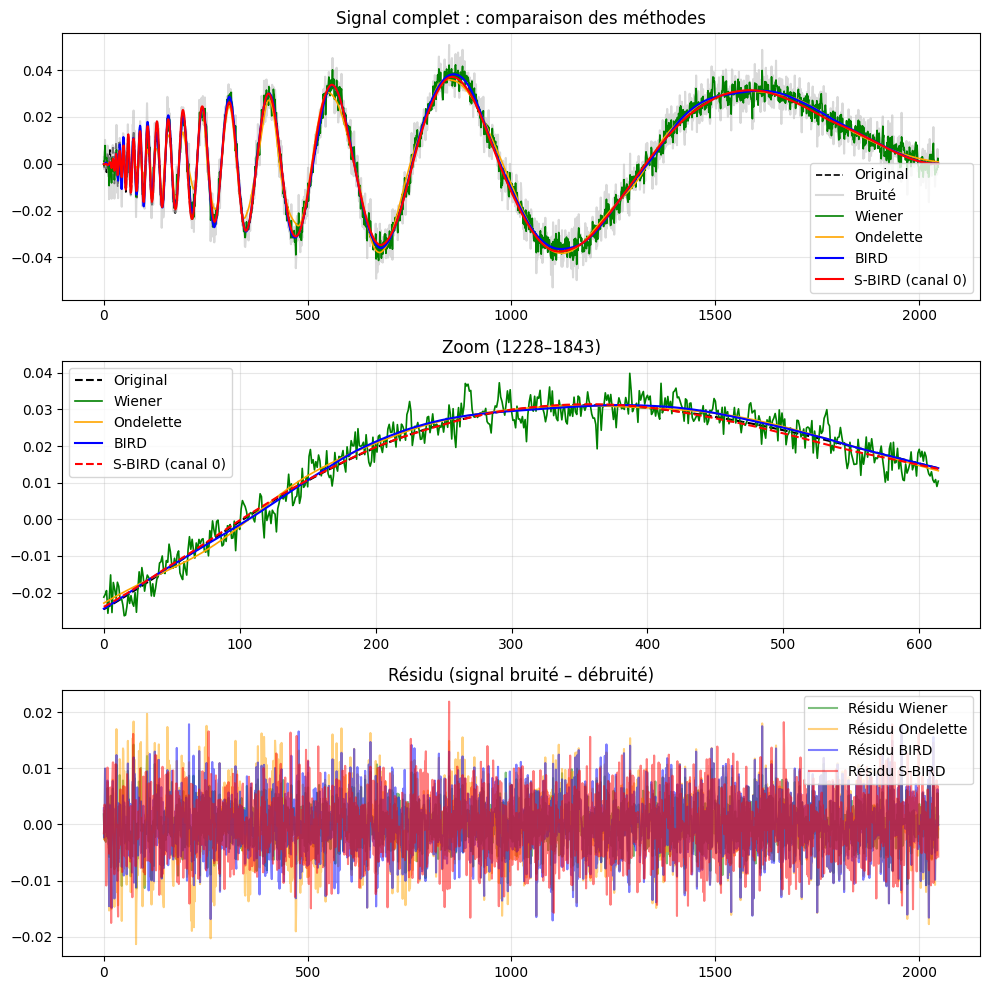

In [ ]:
np.random.seed(42)

# Fonction pour générer le signal propre
def make_doppler(N):
    """Signal test de type Doppler, normalisé en norme 2."""
    t = np.linspace(0, 1, N)
    y = np.sqrt(t * (1 - t)) * np.sin(2 * np.pi * 1.05 / (t + 0.05))
    return y / np.linalg.norm(y)

# Paramètres de l'expérience
N = 2048
SNR_target = 12
n_channels = 5
n_runs = 40
scales = [32, 64, 128, 256, 512, 1024]
P_ABOVE = 1e-7

# Construction des données

clean_sig = make_doppler(N)

# sigma pour atteindre le SNR cible
sigma = np.linalg.norm(clean_sig) * (10 ** (-SNR_target / 20.0))

# bruit mono-canal
noise_mono = np.random.randn(N)
noise_mono = noise_mono / np.linalg.norm(noise_mono) * sigma
noisy_sig = clean_sig + noise_mono

# bruit multi-canaux
X_clean = np.tile(clean_sig, (n_channels, 1))
X_noise = np.random.randn(n_channels, N)
X_noise = (X_noise.T / np.linalg.norm(X_noise, axis=1) * sigma).T
X_noisy = X_clean + X_noise

print(f"--- Simulation (N={N}, SNR={SNR_target} dB, p_above={P_ABOVE}) ---")

# Débruitage

print("1) Wiener (baseline)...")
denoised_wiener = wiener_denoise(noisy_sig, sigma)

print("2) Ondelette (baseline)...")
denoised_wavelet = wavelet_denoise(noisy_sig)

print("3) BIRD (mono-canal)...")
denoised_bird = bird(
    noisy_sig,
    scales=scales,
    n_runs=n_runs,
    p_above=P_ABOVE
)

print("4) S-BIRD (multi-canaux)...")
denoised_sbird = sbird(
    X_noisy,
    scales=scales,
    n_runs=n_runs,
    p_active=1.0,
    p_above=P_ABOVE
)

# Mesures quantitatives

mse_raw = np.mean((clean_sig - noisy_sig) ** 2)
mse_wiener = np.mean((clean_sig - denoised_wiener) ** 2)
mse_wavelet = np.mean((clean_sig - denoised_wavelet) ** 2)
mse_bird = np.mean((clean_sig - denoised_bird) ** 2)
mse_sbird = np.mean((clean_sig - denoised_sbird[0]) ** 2)

def gain_db(mse):
    return 10 * np.log10(mse_raw / mse)

print("\n=== RÉSULTATS ===")
print(f"MSE bruité        : {mse_raw:.2e}")
print(f"MSE Wiener        : {mse_wiener:.2e}  (Gain : +{gain_db(mse_wiener):.2f} dB)")
print(f"MSE Wavelet     : {mse_wavelet:.2e}  (Gain : +{gain_db(mse_wavelet):.2f} dB)")
print(f"MSE BIRD          : {mse_bird:.2e}  (Gain : +{gain_db(mse_bird):.2f} dB)")
print(f"MSE S-BIRD canal0 : {mse_sbird:.2e}  (Gain : +{gain_db(mse_sbird):.2f} dB)")

# Plots
zoom_start, zoom_end = int(0.6 * N), int(0.9 * N)

plt.figure(figsize=(10, 10))

# Signal complet
plt.subplot(3, 1, 1)
plt.title("Signal complet : comparaison des méthodes")
plt.plot(clean_sig, "k--", label="Original", linewidth=1.2)
plt.plot(noisy_sig, "silver", label="Bruité", alpha=0.6)
plt.plot(denoised_wiener, color="green", label="Wiener", linewidth=1.2)
plt.plot(denoised_wavelet, color="orange", label="Wavelet", linewidth=1.2)
plt.plot(denoised_bird, "b", label="BIRD", linewidth=1.5)
plt.plot(denoised_sbird[0], "r", label="S-BIRD (canal 0)", linewidth=1.5)
plt.grid(alpha=0.3)
plt.legend()

# Zoom
plt.subplot(3, 1, 2)
plt.title(f"Zoom ({zoom_start}–{zoom_end})")
plt.plot(clean_sig[zoom_start:zoom_end], "k--", label="Original", linewidth=1.5)
plt.plot(denoised_wiener[zoom_start:zoom_end], color="green", label="Wiener", linewidth=1.2)
plt.plot(denoised_wavelet[zoom_start:zoom_end], color="orange", label="Wavelet", linewidth=1.2)
plt.plot(denoised_bird[zoom_start:zoom_end], "b", label="BIRD", linewidth=1.5)
plt.plot(denoised_sbird[0][zoom_start:zoom_end], "r--", label="S-BIRD (canal 0)", linewidth=1.5)
plt.grid(alpha=0.3)
plt.legend()

# Résidus
plt.subplot(3, 1, 3)
plt.title("Résidu (signal bruité – débruité)")
plt.plot(noisy_sig - denoised_wiener, color="green", alpha=0.5, label="Résidu Wiener")
plt.plot(noisy_sig - denoised_wavelet, color="orange", alpha=0.5, label="Résidu Wavelet")
plt.plot(noisy_sig - denoised_bird, "b", alpha=0.5, label="Résidu BIRD")
plt.plot(X_noisy[0] - denoised_sbird[0], "r", alpha=0.5, label="Résidu S-BIRD")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


### Analyse de l’expérience 1 : BIRD vs S-BIRD

D'abord on voit clairement sur le signal que la baseline wiener est en dessous des autres méthodes. Elle nettoie moins bien le signal, elle oscille trop autour de la GT. Pour ce qui est de la baseline wavelet, on a un gain de seulement 5dB contre 13dB et 16dB pour les méthodes BIRD et S-BIRD, même si qualitativement, on ne voit pas de gros artéfact.

Globalement, cette expérience montre que :

Les baselines classiques Wiener et wavelet permettent un débruitage de base, mais ne capturent pas la structure transitoire du signal.

BIRD améliore la qualité du débruitage sur un canal.

S-BIRD, en exploitant la redondance multi-canaux et le vote structuré, surpasse toutes les autres méthodes en termes de MSE et de préservation des détails.


On voit que les deux méthodes nettoient bien le signal, mais **S-BIRD fait un peu mieux que BIRD**.

Intuition :

- BIRD travaille sur **un seul canal**.  
  Il ne voit qu’un mélange “signal + bruit” et doit deviner tout seul où est le signal.

- S-BIRD voit **plusieurs canaux** avec :
  - le **même signal**,
  - des **bruits indépendants**.

Du coup, ce qui est **cohérent entre les canaux** est probablement du signal,  
et ce qui **change d’un canal à l’autre** est plutôt du bruit.

L’algorithme S-BIRD utilise cette idée dans le **vote structuré** :  
on choisit les atomes qui sont forts sur plusieurs canaux en même temps.  

Résultat :
- les atomes “vraiment signal” sont mieux détectés,
- les atomes qui ne viennent que du bruit sont moins sélectionnés.

C’est pour ça que S-BIRD colle un peu mieux à l’original et laisse un résidu plus proche d’un bruit blanc.



## Expérience 2 : données MEG réelles


On utilise le dataset d’exemple MEG de MNE (réponses auditives). On garde 10 gradiomètres voisins et on filtre le signal entre 1 et 40 Hz.  

On considère ce signal filtré comme la **vérité terrain** $X_{clean}$. On ajoute un bruit blanc gaussien pour obtenir un SNR d’environ $5$dB.  

On teste ensuite :

- **BIRD** sur un seul canal (canal 0)  
- **S-BIRD** sur les 10 canaux en même temps  

On compare la MSE et les courbes temporelles sur le canal 0 (signal propre, BIRD, S-BIRD, et un zoom autour d’un pic d’activité) et on regarge surtout l'influence de `p_active` pour S-BIRD.

Chargement des données MEG Somato...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Données MEG (Somato) : 10 canaux, 301 temps
Canal pic détecté : 15
BIRD mono-canal (canal central)...
BIRD: Lambda=0.1544
S-BIRD multi-canaux, p_active=0.8...
S-BIRD: Lambda=0.1544
S-BIRD multi-canaux, p_active=0.1...
S-BIRD: Lambda=0.1544
MSE Wiener        : 4.05e+03 (Gain : +0.02 dB)
MSE Wavelet       : 4.01e+03 (Gain : +0.06 dB)
MSE bruité        : 4.07e+03
MSE BIRD          : 1.22e+03  (Gain : +5.25 dB)
MSE S-BIRD p=0.8  : 1.13e+04 (Gain : +-4.44 dB)
MSE S-BIRD p=0.1  : 1.16e+03 (Gain : +5.46 dB)


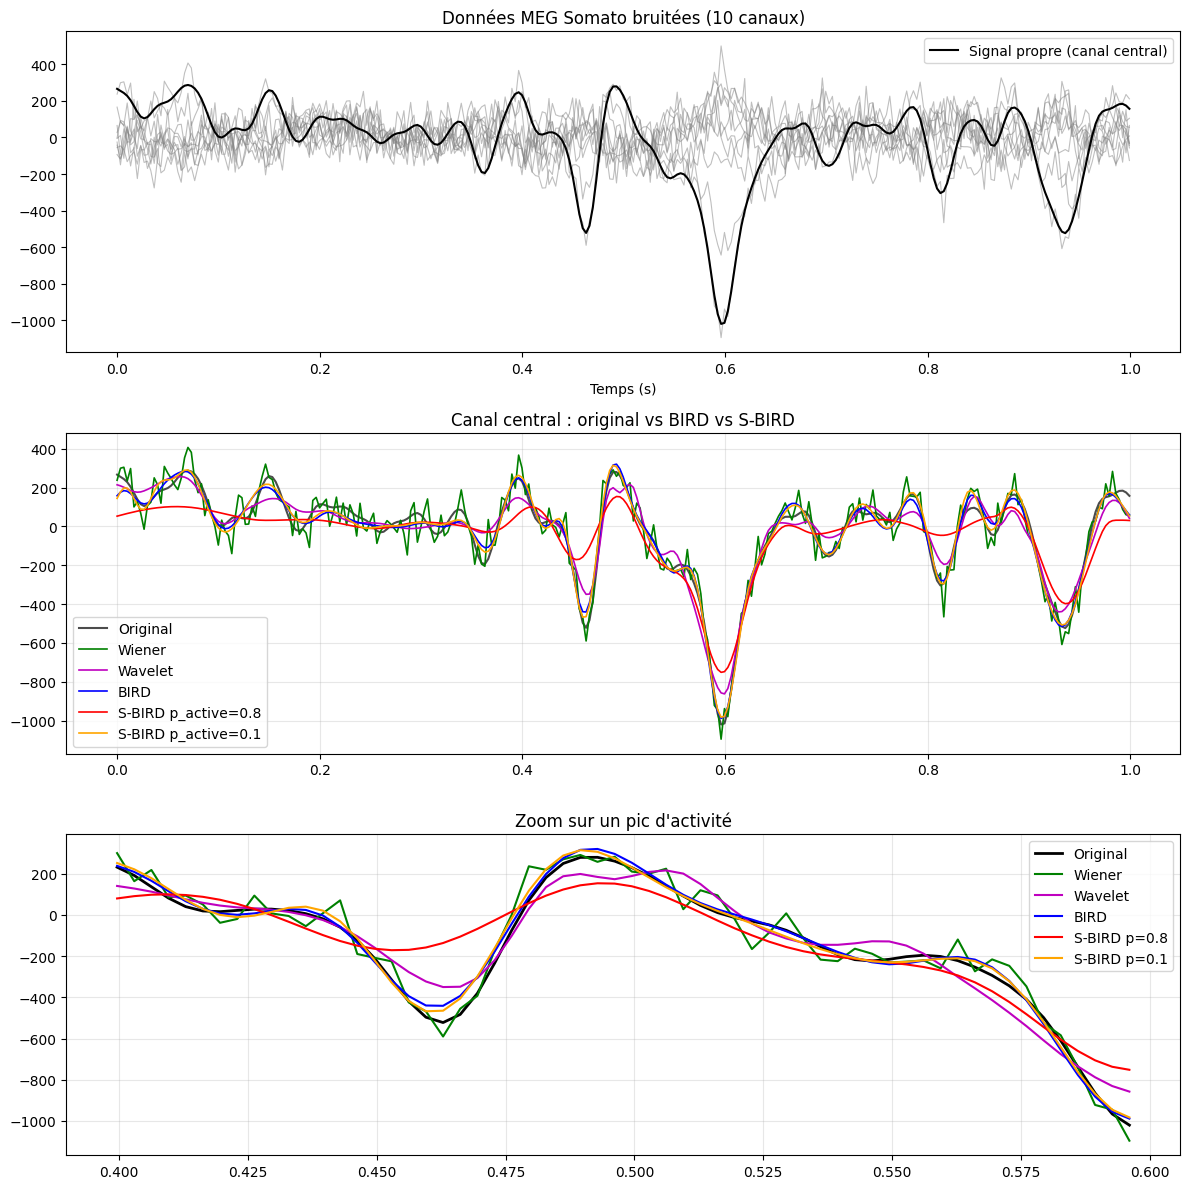

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import mne

np.random.seed(42)

def gain_db(mse):
    return 10 * np.log10(mse_raw / mse)

# =================================================
# 1) Chargement et prétraitement MEG (Somato)
# =================================================
print("Chargement des données MEG Somato...")
data_path = mne.datasets.somato.data_path()
raw_fname = data_path / "sub-01" / "meg" / "sub-01_task-somato_meg.fif"
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)

# Détection des événements (robuste)
events = mne.find_events(raw, verbose=False)
event_id = 1
onset = events[events[:, 2] == event_id, 0][0] / raw.info["sfreq"]

# Prétraitement
raw.pick_types(meg="grad", eeg=False, eog=False, stim=False)
raw.filter(1, 40, verbose=False)

# Fenêtre temporelle autour du stimulus
tmin, tmax = onset - 0.2, onset + 0.8
raw_crop = raw.copy().crop(tmin=tmin, tmax=tmax)

# Sélection automatique des 10 canaux autour du pic d'activité
data_temp = raw_crop.get_data()
peak_idx = np.argmax(np.std(data_temp, axis=1))
roi_channels = range(peak_idx - 5, peak_idx + 5)

X_clean = raw_crop.get_data()[roi_channels, :] * 1e13
n_channels, n_times = X_clean.shape
times = raw_crop.times

print(f"Données MEG (Somato) : {n_channels} canaux, {n_times} temps")
print(f"Canal pic détecté : {peak_idx}")

# Canal central pour l'analyse mono-canal
y_clean = X_clean[5]

# =================================================
# 2) Ajout de bruit artificiel
# =================================================
SNR_target = 5.0

sigma_s = np.linalg.norm(X_clean) / np.sqrt(n_channels * n_times)
sigma_n = sigma_s * (10 ** (-SNR_target / 20.0))

noise = np.random.randn(n_channels, n_times) * sigma_n
X_noisy = X_clean + noise

y_noisy = X_noisy[5]

# =================================================
# Baselines : Wiener et ondelettes
# =================================================
sigma_noise = sigma_n  # connu ici (bruit artificiel)

denoised_wiener = wiener_denoise(y_noisy, sigma_noise)
denoised_wavelet = wavelet_denoise(y_noisy)



# =================================================
# 3) Paramètres communs BIRD / S-BIRD
# =================================================
scales = [32, 64, 128, 256]
n_runs = 30
M = len(scales) * n_times
p_above = 1.0 / M

# =================================================
# 4) BIRD mono-canal
# =================================================
print("BIRD mono-canal (canal central)...")
denoised_bird = bird(
    y_noisy,
    scales=scales,
    n_runs=n_runs,
    p_above=p_above,
)

# =================================================
# 5) S-BIRD multi-canaux (deux p_active)
# =================================================
p_list = [0.8, 0.1]
denoised_sbird = {}

for p_active in p_list:
    print(f"S-BIRD multi-canaux, p_active={p_active}...")
    den_all = sbird(
        X_noisy,
        scales=scales,
        n_runs=n_runs,
        p_active=p_active,
        p_above=p_above,
    )
    denoised_sbird[p_active] = den_all[5]  # canal central

# =================================================
# 6) MSE et gains
# =================================================
mse_raw = np.mean((y_clean - y_noisy) ** 2)
mse_bird = np.mean((y_clean - denoised_bird) ** 2)
mse_sbird_08 = np.mean((y_clean - denoised_sbird[0.8]) ** 2)
mse_sbird_01 = np.mean((y_clean - denoised_sbird[0.1]) ** 2)
mse_wiener = np.mean((y_clean - denoised_wiener) ** 2)
mse_wavelet = np.mean((y_clean - denoised_wavelet) ** 2)

print(f"MSE Wiener        : {mse_wiener:.2e} (Gain : +{gain_db(mse_wiener):.2f} dB)")
print(f"MSE Wavelet       : {mse_wavelet:.2e} (Gain : +{gain_db(mse_wavelet):.2f} dB)")
print(f"MSE bruité        : {mse_raw:.2e}")
print(f"MSE BIRD          : {mse_bird:.2e}  (Gain : +{gain_db(mse_bird):.2f} dB)")
print(f"MSE S-BIRD p=0.8  : {mse_sbird_08:.2e} (Gain : +{gain_db(mse_sbird_08):.2f} dB)")
print(f"MSE S-BIRD p=0.1  : {mse_sbird_01:.2e} (Gain : +{gain_db(mse_sbird_01):.2f} dB)")

# =================================================
# 7) Figures
# =================================================
plt.figure(figsize=(12, 12))

# (1) Données multi-canaux
plt.subplot(3, 1, 1)
plt.title("Données MEG Somato bruitées (10 canaux)")
plt.plot(times, X_noisy.T, color="grey", alpha=0.5, linewidth=0.8)
plt.plot(times, y_clean, "k", linewidth=1.5, label="Signal propre (canal central)")
plt.xlabel("Temps (s)")
plt.legend()

# (2) Comparaison globale
plt.subplot(3, 1, 2)
plt.title("Canal central : original vs BIRD vs S-BIRD")
plt.plot(times, y_clean, "k", lw=1.5, alpha=0.7, label="Original")
plt.plot(times, denoised_wiener, "g", lw=1.2, label="Wiener")
plt.plot(times, denoised_wavelet, "m", lw=1.2, label="Wavelet")
plt.plot(times, denoised_bird, "b", lw=1.2, label="BIRD")
plt.plot(times, denoised_sbird[0.8], "r", lw=1.2, label="S-BIRD p_active=0.8")
plt.plot(times, denoised_sbird[0.1], "orange", lw=1.2, label="S-BIRD p_active=0.1")
plt.grid(alpha=0.3)
plt.legend()

# (3) Zoom
plt.subplot(3, 1, 3)
plt.title("Zoom sur un pic d'activité")
mid = n_times // 2
zoom = slice(mid - 30, mid + 30)
plt.plot(times[zoom], y_clean[zoom], "k", lw=2, label="Original")
plt.plot(times[zoom], denoised_wiener[zoom], "g", lw=1.5, label="Wiener")
plt.plot(times[zoom], denoised_wavelet[zoom], "m", lw=1.5, label="Wavelet")
plt.plot(times[zoom], denoised_bird[zoom], "b", lw=1.5, label="BIRD")
plt.plot(times[zoom], denoised_sbird[0.8][zoom], "r", lw=1.5, label="S-BIRD p=0.8")
plt.plot(times[zoom], denoised_sbird[0.1][zoom], "orange", lw=1.5, label="S-BIRD p=0.1")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


### Analyse des résultats MEG et rôle de `p_active`

Quand `p_active` est élevé (par exemple \(0.8\)), S-BIRD demande qu’un atome soit fort sur la **majorité** des capteurs pour être accepté. C’est une logique de “vote massif”.

Mais une source MEG est souvent **locale** : le champ magnétique forme un dipôle, fort sur quelques capteurs, faible ou presque nul sur les voisins.

Avec un `p_active` trop grand :
- les atomes forts sur 1 ou 2 capteurs sont souvent rejetés  
- l’algorithme prend ces pics locaux pour du bruit  
- le résultat est trop lissé et la réponse évoquée est écrasée

En baissant `p_active` (par exemple à \(0.1\)) :
- on autorise S-BIRD à valider un atome dès qu’il est clairement présent sur **au moins un capteur**  
- les sources localisées sont mieux capturées  
- on suit mieux la forme des pics sans tuer les détails

Dans ce cas, l’algorithme devient plus “intelligent” : il comprend qu’un signal net et bien structuré sur un capteur isolé a peu de chances d’être du simple bruit aléatoire. Il décide donc de faire confiance à ce capteur, tout en nettoyant le reste grâce au dictionnaire.

Au fond, c’est un compromis **sécurité vs sensibilité** :
- `p_active` haut → très sûr contre les artefacts d’un seul capteur,  
  mais risque de supprimer un vrai signal local.  
- `p_active` bas → on sauve les signaux locaux,  
  mais on accepte le risque de conserver un artefact isolé.

Il n’y a pas de valeur magique de \(p\). On doit s’appuyer sur la **physique de l’expérience** : en MEG, on sait que les sources sont souvent très locales → on préfère baisser \(p\) et accepter quelques artefacts plutôt que rater un vrai signal biologique bien localisé.

Text(0.5, 0, 'Temps (s)')

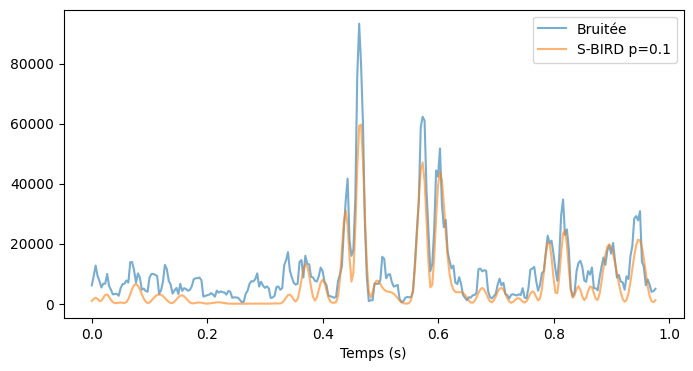

In [29]:
def sliding_variance(x, win):
    return np.array([
        np.var(x[i:i+win])
        for i in range(len(x) - win)
    ])
fs = 150
win = int(0.05 * fs)

var_noisy = sliding_variance(y_noisy, win)
var_sbird = sliding_variance(denoised_sbird[0.1], win)
plt.figure(figsize=(8,4))
plt.plot(times[:-win], var_noisy, label="Bruitée", alpha=0.6)
plt.plot(times[:-win], var_sbird, label="S-BIRD p=0.1", alpha=0.6)
plt.legend()
plt.xlabel("Temps (s)")

## Expérience 3 : bursts cachés et rôle de `p_above`


On construit un signal synthétique avec trois bursts bien séparés. On duplique ce signal sur 8 canaux et on ajoute un bruit blanc très fort. (SNR = −2 dB, le bruit est plus fort que le signal).

On applique ensuite :
- BIRD sur le canal 0  
- S-BIRD sur les 8 canaux

On teste deux valeurs de `p_above` :
- `p_above = 0.2` : critère très permissif, l’algorithme va loin dans les itérations  
- `p_above = 2e-5` : critère très strict, l’algorithme s’arrête tôt

On trace le signal bruité, la vérité et les sorties BIRD / S-BIRD pour les deux cas.

SNR = -2 dB, 8 canaux

=== p_above = 0.2 ===
BIRD: Lambda=0.0474
S-BIRD: Lambda=0.0474
MSE BIRD   : 0.0070
MSE S-BIRD : 0.0002

=== p_above = 2e-05 ===
BIRD: Lambda=0.0621
S-BIRD: Lambda=0.0621
MSE BIRD   : 0.0005
MSE S-BIRD : 0.0002


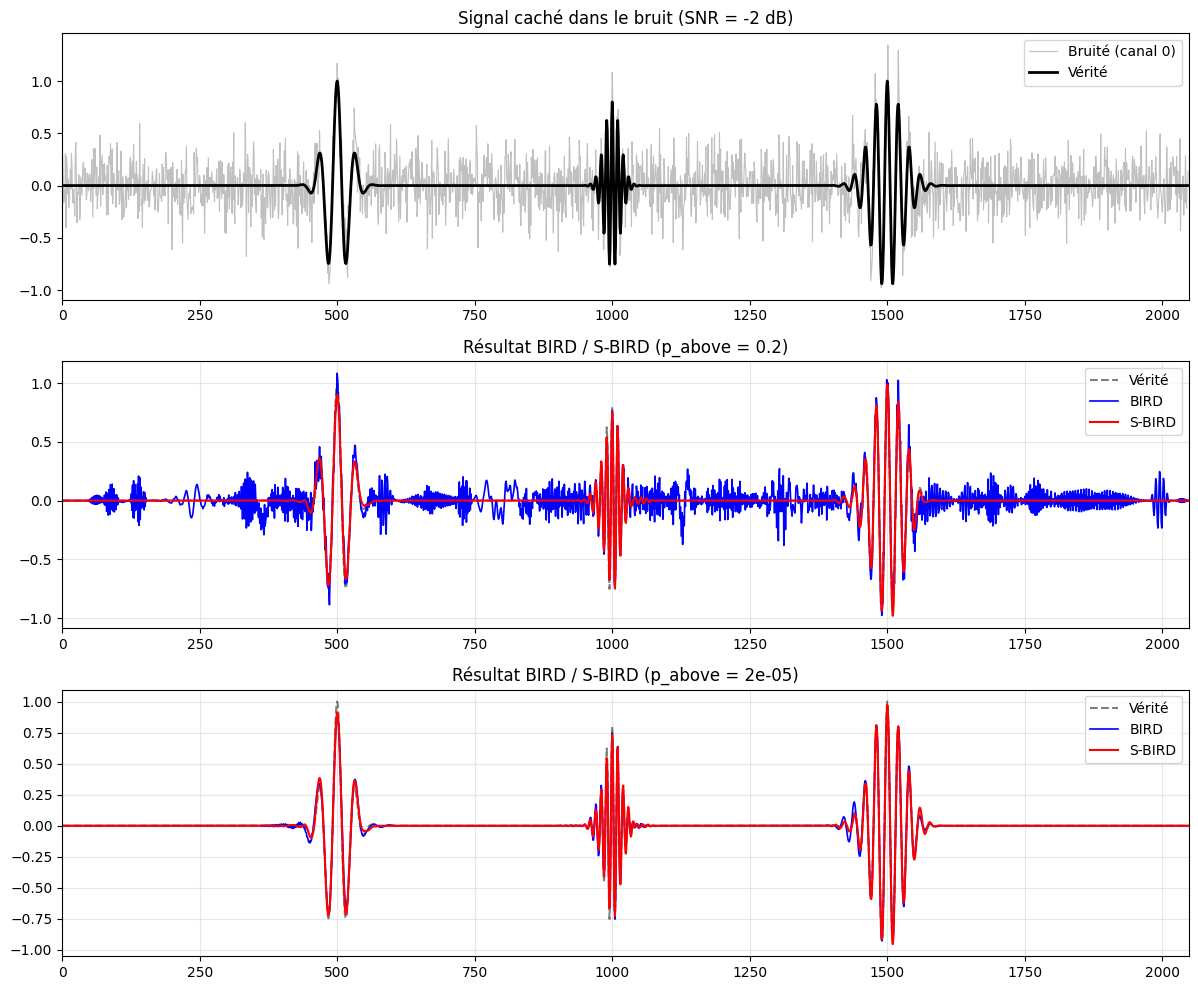

In [ ]:
# Expérience 3 : bursts cachés, effet de p_above (0.2 vs 0.00002)


# 1) Signal de test : 3 bursts
def make_bursts(N):
    t = np.arange(N)
    sig = np.zeros(N)
    sig += 5.0 * np.exp(-((t - 500)/30)**2)  * np.cos(2*np.pi*0.03*t)
    sig += 4.0 * np.exp(-((t - 1000)/20)**2) * np.cos(2*np.pi*0.10*t)
    sig += 5.0 * np.exp(-((t - 1500)/40)**2) * np.cos(2*np.pi*0.05*t)
    return sig / np.max(np.abs(sig))

N = 2048
n_channels = 8
scales = [32, 64, 128]
n_runs = 40

clean_sig = make_bursts(N)
X_clean = np.tile(clean_sig, (n_channels, 1))

# 2) Bruit très fort (SNR négatif)
np.random.seed(999)
SNR = -2
sigma = np.linalg.norm(clean_sig) * 10**(-SNR / 20.0)

noise = np.random.randn(n_channels, N)
X_noise = (noise.T / np.linalg.norm(noise, axis=1) * sigma).T
X_noisy = X_clean + X_noise

print(f"SNR = {SNR} dB, 8 canaux")

# 3) On teste deux valeurs de p_above
p_values = [0.2, 2e-5]
results = {}

for p_above in p_values:
    print(f"\n=== p_above = {p_above} ===")
    # BIRD sur le canal 0
    den_bird = bird(X_noisy[0], scales=scales, n_runs=n_runs, p_above=p_above)
    # S-BIRD sur les 8 canaux
    den_sbird_all = sbird(
        X_noisy,
        scales=scales,
        n_runs=n_runs,
        p_active=1.0,
        p_above=p_above,
    )
    den_sbird = den_sbird_all[0]

    mse_bird = np.mean((clean_sig - den_bird)**2)
    mse_sbird = np.mean((clean_sig - den_sbird)**2)
    results[p_above] = (den_bird, den_sbird, mse_bird, mse_sbird)

    print(f"MSE BIRD   : {mse_bird:.4f}")
    print(f"MSE S-BIRD : {mse_sbird:.4f}")

# 4) Tracés
plt.figure(figsize=(12, 10))

# signal bruité vs vérité
plt.subplot(3, 1, 1)
plt.title(f"Signal caché dans le bruit (SNR = {SNR} dB)")
plt.plot(X_noisy[0], "silver", lw=0.8, label="Bruité (canal 0)")
plt.plot(clean_sig, "k", lw=2, label="Vérité")
plt.legend()
plt.xlim(0, N)

# cas p_above = 0.2
plt.subplot(3, 1, 2)
p = p_values[0]
den_bird, den_sbird, _, _ = results[p]
plt.title(f"Résultat BIRD / S-BIRD (p_above = {p})")
plt.plot(clean_sig, "k--", alpha=0.5, label="Vérité")
plt.plot(den_bird, "b", lw=1.2, label="BIRD")
plt.plot(den_sbird, "r", lw=1.5, label="S-BIRD")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, N)

# cas p_above = 2e-5
plt.subplot(3, 1, 3)
p = p_values[1]
den_bird, den_sbird, _, _ = results[p]
plt.title(f"Résultat BIRD / S-BIRD (p_above = {p})")
plt.plot(clean_sig, "k--", alpha=0.5, label="Vérité")
plt.plot(den_bird, "b", lw=1.2, label="BIRD")
plt.plot(den_sbird, "r", lw=1.5, label="S-BIRD")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, N)

plt.tight_layout()
plt.show()

### Analyse : effet de `p_above` sur BIRD et S-BIRD

`p_above` contrôle jusqu’où on autorise l’algorithme à “creuser” dans le bruit.

- Avec `p_above = 0.2` :  
  - BIRD travaille en solo sur un capteur.  
    Il prend facilement des gros pics de bruit pour du signal et rajoute des bursts qui n’existent pas.  
  - S-BIRD regarde les 8 canaux.  
    Le vrai burst est présent sur tous les canaux, le bruit ne l’est pas car mais il est indépendant d’un canal à l’autre. C’est ça qui donne l’avantage à S-BIRD :
    le vrai burst est aligné sur tous les canaux, alors que les gros pics de bruit n’arrivent pas au même endroit sur les 8 en même temps (ou très rarement).
    S-BIRD reconstruit donc beaucoup mieux la forme des bursts.

- Avec `p_above = 2e-5` :  
  - Le seuil devient très strict.  
  - BIRD reste très conservateur et laisse encore pas mal de bruit, voire manque une partie des bursts.  
  - S-BIRD reste plus robuste : il récupère les bursts principaux mais avec une amplitude un peu réduite.

On voit donc deux choses :

1. Un `p_above` trop grand peut faire sur-apprendre le bruit, surtout pour BIRD.  
2. Un `p_above` trop petit coupe tôt, mais S-BIRD reste avantagé grâce à l’information multi-canaux.

BIRD est un nettoyeur polyvalent qui traite chaque canal isolément, tandis que S-BIRD est un nettoyeur intelligent qui exploite la redondance entre les capteurs pour écraser le bruit massif, à condition que le signal soit physiquement cohérent spatialement.

## Expérience 4 : signaux désynchronisés



Dans cette expérience, on simule une petite onde qui se propage avec un **retard fixe** sur 5 capteurs. Le même pulse arrive d’abord sur le canal 0, puis 50 samples plus tard sur le canal 1, etc.  

On ajoute un bruit blanc gaussien pour obtenir un SNR modéré.  
On applique ensuite :

- **BIRD** sur tous les canaux, mais de façon **indépendante** (canal par canal)  
- **S-BIRD** avec une structure **très stricte** $p_{\text{active}} = 1.0$

On trace, pour chaque canal, le signal bruité, la vérité décalée, et les estimations BIRD / S-BIRD.

Test désynchronisation : delay=50 samples, SNR=8 dB
BIRD: Lambda=0.0878
S-BIRD: Lambda=0.0878


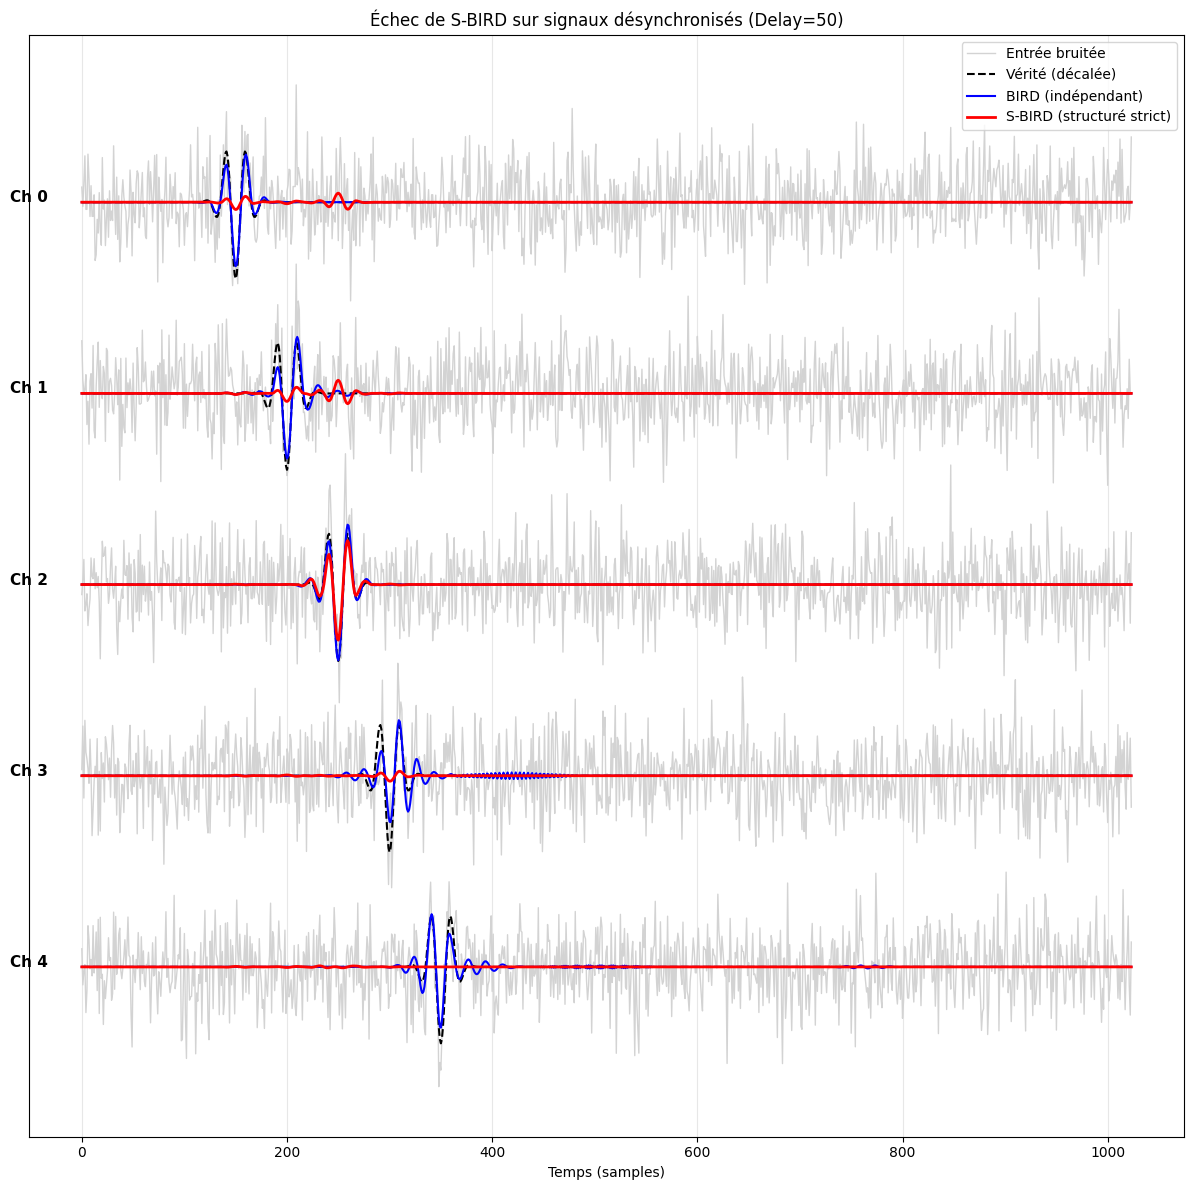

S-BIRD: Lambda=0.0878


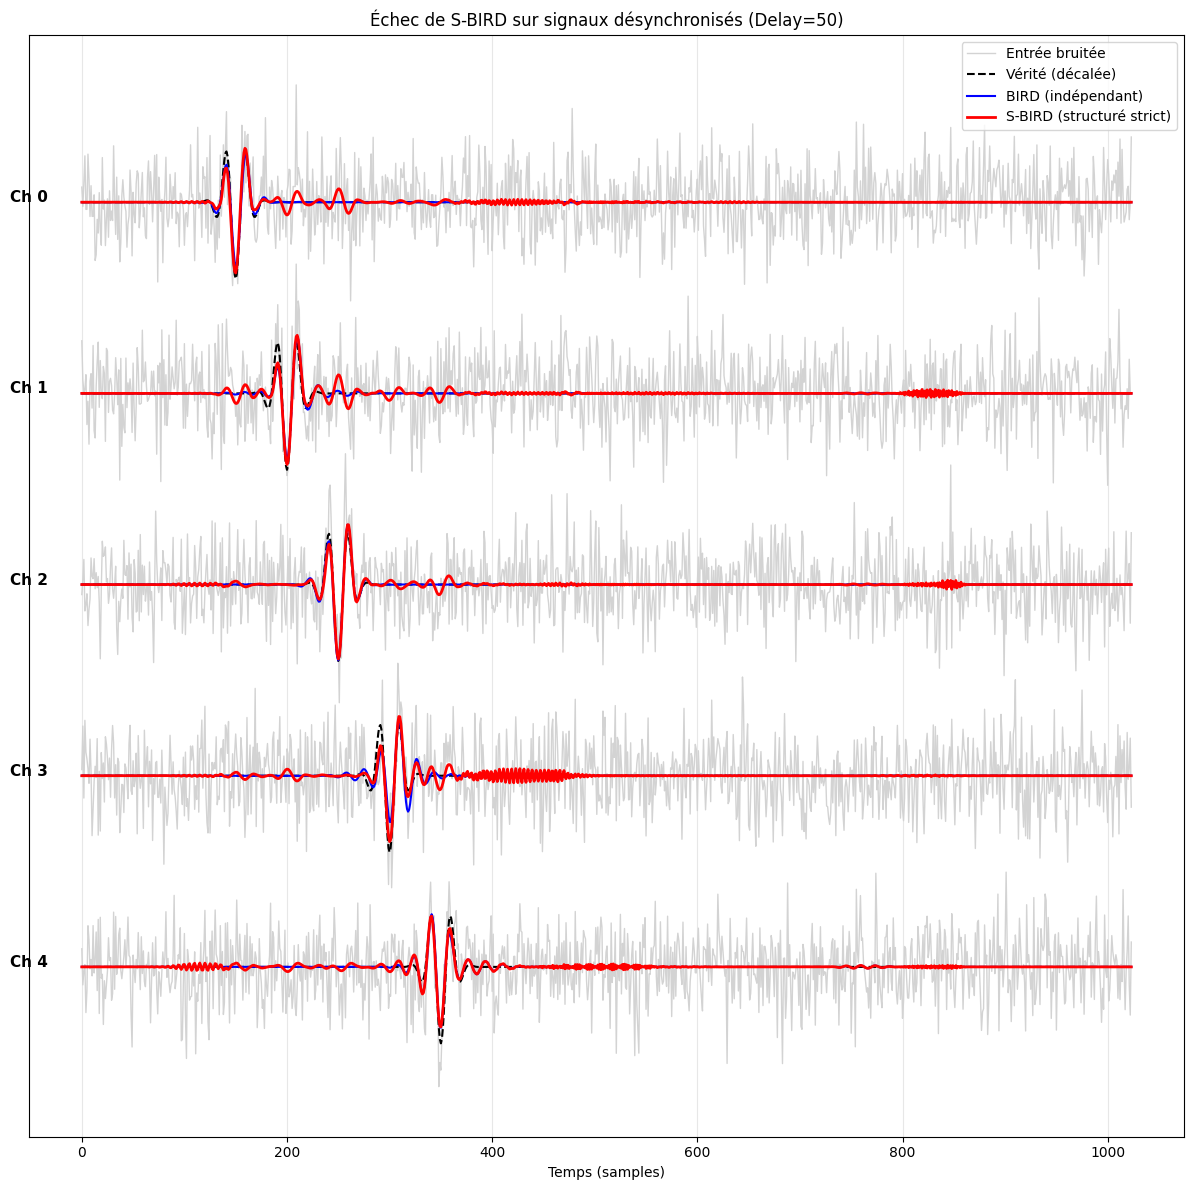

In [8]:
# Expérience 4 : désynchronisation, BIRD vs S-BIRD

np.random.seed(42)

# 1) Signal de base : petite onde centrée vers t=150
N = 1024
n_channels = 5
scales = [32, 64, 128]
n_runs = 40

t = np.arange(N)
pulse = np.exp(-((t - 150)/15)**2) * np.cos(2*np.pi*0.05*t)
pulse = pulse / np.max(np.abs(pulse))

# 2) On crée 5 canaux avec retard croissant
delay = 50
X_clean = np.zeros((n_channels, N))
for c in range(n_channels):
    X_clean[c] = np.roll(pulse, c * delay)

# 3) On ajoute du bruit (SNR modéré)
SNR = 8
sigma = 10**(-SNR / 20.0)
noise = np.random.randn(n_channels, N) * sigma
X_noisy = X_clean + noise

print(f"Test désynchronisation : delay={delay} samples, SNR={SNR} dB")

# 4) BIRD indépendant par canal
denoised_bird = bird(X_noisy, scales=scales, n_runs=n_runs, p_above=1e-5)

# 5) S-BIRD structuré strict (p_active=0.8)
denoised_sbird = sbird(X_noisy, scales=scales, n_runs=n_runs,
                       p_above=1e-5, p_active=0.8)

# 6) Affichage
plt.figure(figsize=(12, 12))
plt.title(f"Échec de S-BIRD sur signaux désynchronisés (Delay={delay})")

offset = 2.5
for c in range(n_channels):
    base = -c * offset
    lbl_noise = "Entrée bruitée" if c == 0 else None
    lbl_clean = "Vérité (décalée)" if c == 0 else None
    lbl_bird  = "BIRD (indépendant)" if c == 0 else None
    lbl_sbird = "S-BIRD (structuré strict)" if c == 0 else None

    plt.plot(X_noisy[c] + base, color="lightgrey", lw=1, label=lbl_noise)
    plt.plot(X_clean[c] + base, "k--", lw=1.5, label=lbl_clean)
    plt.plot(denoised_bird[c] + base, "b", lw=1.5, label=lbl_bird)
    plt.plot(denoised_sbird[c] + base, "r", lw=2.0, label=lbl_sbird)

    plt.text(-70, base, f"Ch {c}", fontsize=11, fontweight="bold")

plt.yticks([])
plt.xlabel("Temps (samples)")
plt.grid(alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# 5) S-BIRD moins strict (p_active=0.3)
denoised_sbird = sbird(X_noisy, scales=scales, n_runs=n_runs,
                       p_above=1e-5, p_active=0.3)

# 6) Affichage
plt.figure(figsize=(12, 12))
plt.title(f"Échec de S-BIRD sur signaux désynchronisés (Delay={delay})")

offset = 2.5
for c in range(n_channels):
    base = -c * offset
    lbl_noise = "Entrée bruitée" if c == 0 else None
    lbl_clean = "Vérité (décalée)" if c == 0 else None
    lbl_bird  = "BIRD (indépendant)" if c == 0 else None
    lbl_sbird = "S-BIRD (structuré strict)" if c == 0 else None

    plt.plot(X_noisy[c] + base, color="lightgrey", lw=1, label=lbl_noise)
    plt.plot(X_clean[c] + base, "k--", lw=1.5, label=lbl_clean)
    plt.plot(denoised_bird[c] + base, "b", lw=1.5, label=lbl_bird)
    plt.plot(denoised_sbird[c] + base, "r", lw=2.0, label=lbl_sbird)

    plt.text(-70, base, f"Ch {c}", fontsize=11, fontweight="bold")

plt.yticks([])
plt.xlabel("Temps (samples)")
plt.grid(alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Analyse : pourquoi S-BIRD échoue ici

Les signaux sont **désynchronisés** : le pulse n’est jamais présent **au même instant** sur les 5 canaux.

- BIRD traite chaque canal séparément.  
  Il ne fait aucune hypothèse de synchronisation, donc il retrouve bien le pulse sur chaque capteur.

- S-BIRD, avec `p_active = 0.8`, impose un consensus total : pour activer un atome, il faut qu’il soit fort **en même temps** sur tous les canaux. Or, à cause du retard, quand un canal voit le pulse, les autres sont presque plats.       S-BIRD interprète alors cette activité isolée comme du bruit local et l’écrase.

Résultat :  
les courbes BIRD (bleu) suivent bien la vérité, tandis que les courbes S-BIRD (rouge) restent presque à zéro.

Pour corriger ce comportement, il faudrait soit :
- **baisser `p_active`** (par exemple 0.4 ou 0.2) pour accepter des pulses présents seulement sur une partie des capteurs,  
- soit **ré-aligner les canaux dans le temps** avant d’appliquer S-BIRD.

### Réalignement des canaux avant S-BIRD

Dans cette suite, on garde exactement le même dataset que dans l’expérience précédente : un pulse qui arrive avec un **retard fixe** de 50 samples entre chaque canal, plus du bruit blanc.

On ajoute une étape simple :

1. on **réaligne** les canaux en annulant le retard connu \(c \times \text{delay}\)  
   (on “ramène” tous les pulses au même temps) ;
2. on applique **S-BIRD multi-canaux** avec `p_active = 1.0` sur ces signaux synchronisés ;
3. on **re-déplace** ensuite chaque canal pour revenir dans le repère original.

BIRD: Lambda=0.0878
S-BIRD: Lambda=0.0878
S-BIRD: Lambda=0.0878


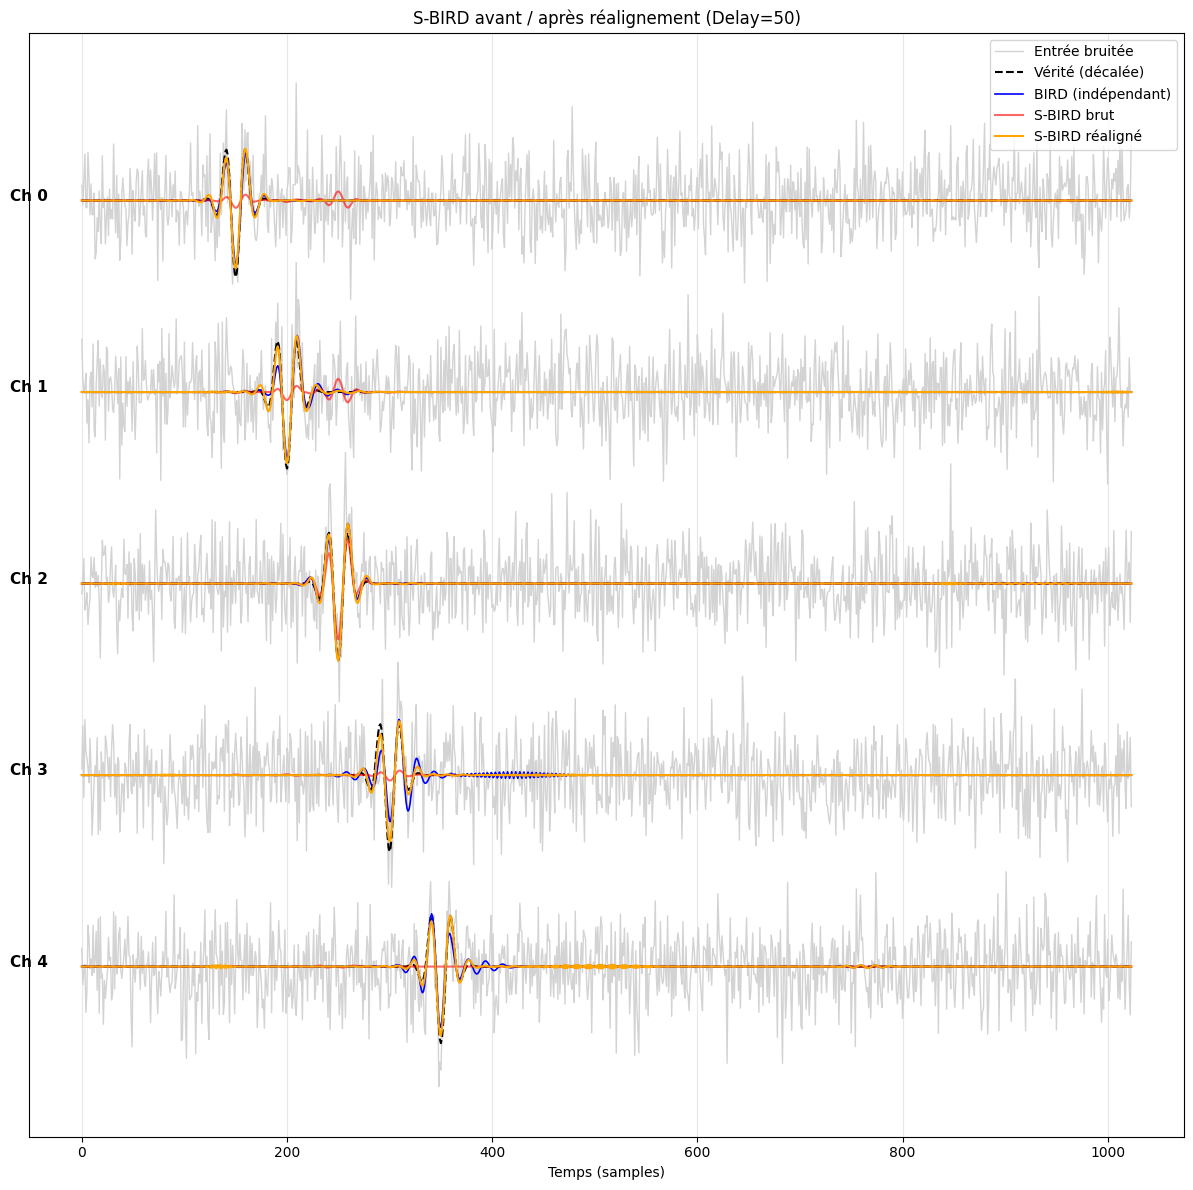

In [9]:
# Suite de l'expérience 4 : réaligner les canaux avant S-BIRD
np.random.seed(42)

# 1) Même dataset que avant : pulse décalé de 50 samples par canal
N = 1024
n_channels = 5
scales = [32, 64, 128]
n_runs = 40
delay = 50

t = np.arange(N)
pulse = np.exp(-((t - 150)/15)**2) * np.cos(2*np.pi*0.05*t)
pulse = pulse / np.max(np.abs(pulse))

X_clean = np.zeros((n_channels, N))
for c in range(n_channels):
    X_clean[c] = np.roll(pulse, c * delay)

SNR = 8
sigma = 10**(-SNR / 20.0)
noise = np.random.randn(n_channels, N) * sigma
X_noisy = X_clean + noise

# 2) BIRD (baseline, canal par canal)
den_bird = bird(X_noisy, scales=scales, n_runs=n_runs, p_above=1e-5)

# 3) S-BIRD sans réalignement (échec)
den_sbird_raw = sbird(
    X_noisy, scales=scales, n_runs=n_runs,
    p_above=1e-5, p_active=1.0
)

# 4) Réalignement simple des canaux
# On annule le retard c * delay sur chaque canal
X_noisy_align = np.zeros_like(X_noisy)
for c in range(n_channels):
    X_noisy_align[c] = np.roll(X_noisy[c], -c * delay)

# 5) S-BIRD après réalignement (hypothèse "même temps" respectée)
den_sbird_align_sync = sbird(
    X_noisy_align, scales=scales, n_runs=n_runs,
    p_above=1e-5, p_active=1.0
)

# 6) On remet les canaux S-BIRD alignés dans le repère original
den_sbird_align = np.zeros_like(den_sbird_align_sync)
for c in range(n_channels):
    den_sbird_align[c] = np.roll(den_sbird_align_sync[c], c * delay)

# 7) Affichage : BIRD vs S-BIRD brut vs S-BIRD réaligné
plt.figure(figsize=(12, 12))
plt.title(f"S-BIRD avant / après réalignement (Delay={delay})")

offset = 2.5
for c in range(n_channels):
    base = -c * offset
    lbl_noise  = "Entrée bruitée" if c == 0 else None
    lbl_clean  = "Vérité (décalée)" if c == 0 else None
    lbl_bird   = "BIRD (indépendant)" if c == 0 else None
    lbl_s_raw  = "S-BIRD brut" if c == 0 else None
    lbl_s_align= "S-BIRD réaligné" if c == 0 else None

    plt.plot(X_noisy[c] + base, color="lightgrey", lw=1, label=lbl_noise)
    plt.plot(X_clean[c] + base, "k--", lw=1.5, label=lbl_clean)
    plt.plot(den_bird[c] + base, "b", lw=1.2, label=lbl_bird)
    plt.plot(den_sbird_raw[c] + base, "r", lw=1.5, alpha=0.6, label=lbl_s_raw)
    plt.plot(den_sbird_align[c] + base, "orange", lw=1.5, label=lbl_s_align)

    plt.text(-70, base, f"Ch {c}", fontsize=11, fontweight="bold")

plt.yticks([])
plt.xlabel("Temps (samples)")
plt.grid(alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Résultat :

- S-BIRD **brut** (sans réalignement) échoue dès qu’il y a du retard :  il suppose que tout doit être synchronisé, donc il supprime ou déforme le pulse.
- Après réalignement, l’hypothèse de S-BIRD devient vraie :  le même atome temps–fréquence est bien présent en même temps sur tous les canaux.
- Dans ce cas, S-BIRD réaligné reconstruit bien le pulse sur chaque capteur,  tout en gardant la structure multi-canaux et en réduisant le bruit.

Cette petite expérience montre que :

- S-BIRD est très puissant **si on respecte son modèle** (synchronisation des canaux) ;  
- dès qu’il y a des retards, il vaut mieux **corriger la désynchronisation** avant de lancer S-BIRD,  ou alors revenir à une approche plus locale (BIRD canal par canal).